In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from numpy import newaxis
from math import ceil
import matplotlib.pyplot as plt
import sys
sys.path.append('../data_generator')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from data_utils import SerieToPieces, DatasetAbsoluteDiscretization
from scipy import sparse
'''
import plotly
plotly.tools.set_credentials_file(username='duxin', api_key='Hs3BeQkqPUCIfaMTgyZi')
import plotly.plotly as py
import plotly.graph_objs as go
'''
import multiprocessing

import price_util

/home/duxin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/duxin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from sklearn.preprocessing import MinMaxScaler
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Activation, TimeDistributed, AveragePooling1D, Average, Reshape, Flatten
from keras import regularizers
from keras.utils import plot_model
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [3]:
'''
def load_data(file_name, sequence_length=10, split=0.8):
    df = pd.read_csv(file_name, sep=',', usecols=[1])
    data_all = np.array(df).astype(float)
    scaler = MinMaxScaler()
    data_all = scaler.fit_transform(data_all)
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')
    np.random.shuffle(reshaped_data)
    
    x = reshaped_data[:, :-1]
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y, scaler
'''


def build_model_sequential():
    # input_dim是输入的train_x的最后一个维度，train_x的维度为(n_samples, time_steps, input_dim)
    model = Sequential()
    model.add(LSTM(100, input_dim=1, input_length = 50, return_sequences=True))
    #print(model.layers)
    #model.add(LSTM(100, return_sequences=True))
    #model.add(LSTM(100, return_sequences=True))
    #model.add(AveragePooling1D(pool_size = 100))
    model.add(AveragePooling1D(pool_size = 50))
    model.add(Dense(output_dim=1))
    model.add(Activation('linear'))

    model.compile(loss='mse', optimizer='rmsprop')
    return model

def build_model():
    inputs = Input(shape = (50, 1))
    lstm1 = LSTM(100, return_sequences = True)(inputs)
    lstm2 = LSTM(100, return_sequences = True)(lstm1)
    lstm3 = LSTM(100, return_sequences = True)(lstm2)
    #reshape1 = Reshape((-1,))(lstm5)
    flatten1 = Flatten()(lstm3)
    predicts = Dense(1, activation = 'linear', 
                     kernel_regularizer = regularizers.l2(0.2))(flatten1)
    model = Model(inputs = inputs, outputs = predicts)
    model.compile(loss = 'mse', optimizer = 'rmsprop')
    return model

def train_model(train_x, train_y, epochs = 2):
    model = build_model()
    plot_model(model, 'archi.png')

    try:
        model.fit(train_x, train_y, batch_size=128, epochs=epochs, validation_split=0.1)
    except KeyboardInterrupt:
        print('Interrupted by Keyboard')
    #print(predict)
    #print(test_y)
    #try:
    #    fig = plt.figure(1)
    #plt.plot(predict[:500], 'r:')
    #    plt.plot(test_y[:500], 'g-')
    #    plt.legend(['predict', 'true'])
    #except Exception as e:
    #    print(e)
    return model

In [46]:
if __name__ == '__main__':
    data = np.load('../data/Sin_1_10000.npy')
    #data = data[:100000]
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape([-1,1]))
    train_x,train_y,valid_x,valid_y,test_x,test_y = SerieToPieces(data, valid_ratio = 0.0, test_ratio = 0.01, shuffle = True)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    
    model = train_model(train_x, train_y, epochs = 5)
    
    train_x = train_x[:1000]
    train_y = train_y[:1000]
    
    predict_train = model.predict(train_x)
    #predict_train = scaler.inverse_transform(predict_train.reshape([-1, 1]))
    #train_y = scaler.inverse_transform(train_y)
    predict_test = model.predict(test_x)
    #predict_test = scaler.inverse_transform(predict_test.reshape([-1, 1]))
    #test_y = scaler.inverse_transform(test_y)
    print('Finished.')

Train on 8865 samples, validate on 985 samples
Epoch 1/5
8865/8865 [==============================] - 11s - loss: 0.1363 - val_loss: 0.0317
Epoch 2/5
8865/8865 [==============================] - 11s - loss: 0.0288 - val_loss: 0.0239
Epoch 3/5
8865/8865 [==============================] - 11s - loss: 0.0194 - val_loss: 0.0219
Epoch 4/5
8865/8865 [==============================] - 11s - loss: 0.0157 - val_loss: 0.0082
Epoch 5/5
8865/8865 [==============================] - 11s - loss: 0.0133 - val_loss: 0.0075
Finished.


In [47]:
data.shape

(10000, 1)

In [55]:
plot_model(model, 'arch.png')

In [10]:
predict_test[500:1000].shape

(0, 1)

In [11]:
model.layers

In [33]:
l = model.layers[-2]
l.input_shape

(None, 50, 100)

In [126]:
model.layers[-1].get_weights()[0].T[0].shape

(5000,)

In [452]:
l = model.layers[-1]
l.output_shape
l.get_weights()[0].shape

(5000, 32)

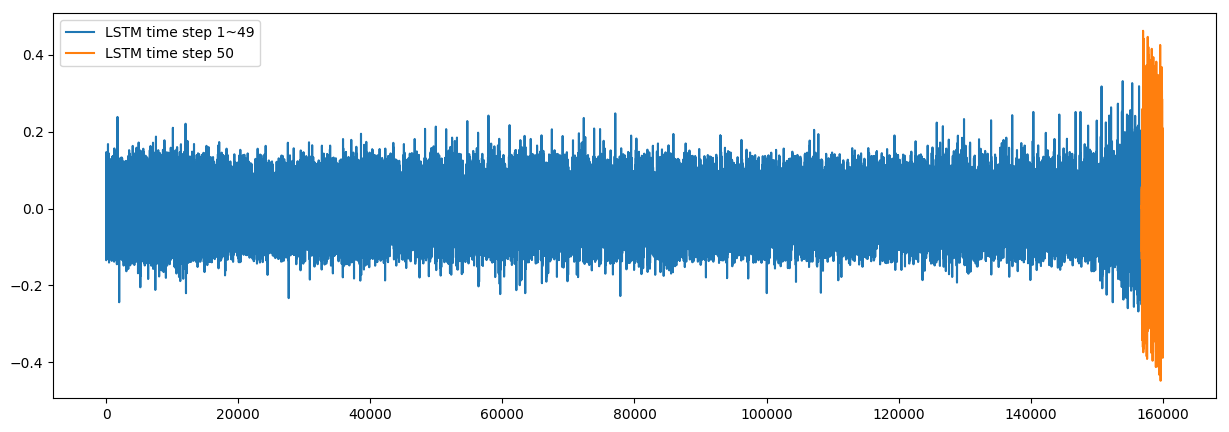

In [457]:
plt.figure(figsize=(15,5))
l = model.layers[-1]
weights = l.get_weights()[0].reshape(-1)
plt.plot(range(156800), weights[:-3200], label = 'LSTM time step 1~49')
plt.plot(range(156800,160000), weights[-3200:], label = 'LSTM time step 50')
plt.legend()

mse of test set : 0.0030184113007875003
mse of train set: 0.0029066356284496095


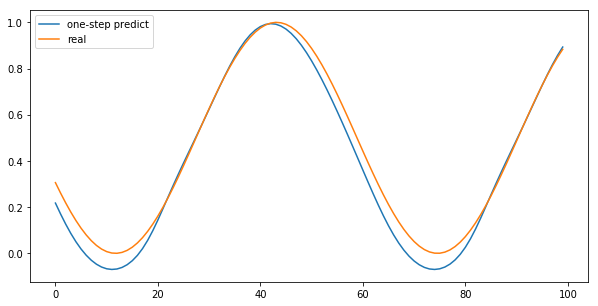

In [49]:
plt.figure(figsize = (10,5))
plt.plot(predict_test[0:100], label = 'one-step predict')
plt.plot(test_y[0:100], label = 'real')
plt.legend()
print('mse of test set :', mse(predict_test, test_y))
print('mse of train set:', mse(predict_train, train_y))

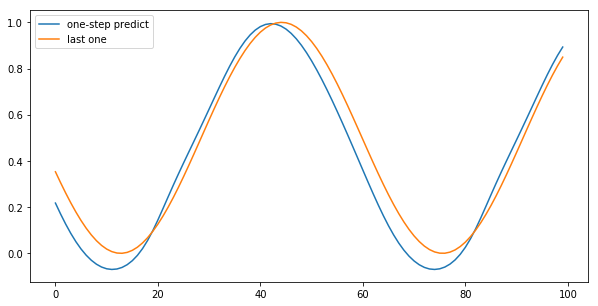

In [50]:
plt.figure(figsize = (10,5))
plt.plot(predict_test[0:500], label = 'one-step predict')
plt.plot(test_x[0:500, -1, 0], label = 'last one')
plt.legend()

In [ ]:
error = np.abs(predict_test - test_y)
h = plt.hist(error, bins = 100)

In [42]:
def do_predict(model, x):
    predict = model.predict(x)
    predict = np.reshape(predict, (predict.size, ))
    return predict

def do_multistep_predict(model, x, n_step):
    y_hist = []
    for i in range(n_step):
        #print('progress: %d / %d'%(i+1, n_step))
        y = do_predict(model, x)
        #print(y)
        y_hist.append(y)
        x = np.hstack([x[:,1:,0], y.reshape([-1, 1])])[:,:,newaxis]
        #x = np.hstack([x[:,1:,0], test_x[0+i+1:250+i+1:50, -1, :]])[:,:,newaxis]
    y_hist = np.array(y_hist).T
    return y_hist

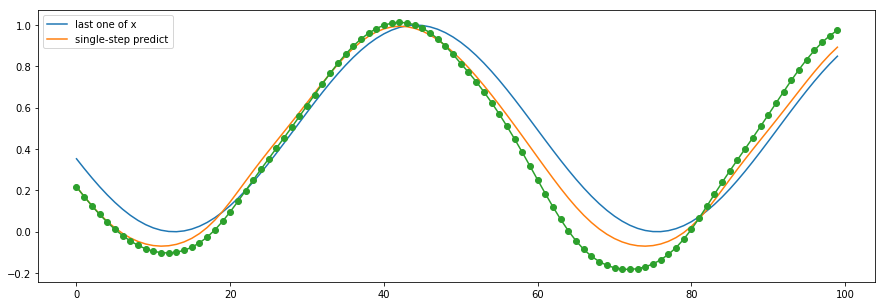

In [56]:
multi_predict_lag = 100
num_groups = 10
show_from = 0
show_end = show_from + multi_predict_lag * num_groups
#data = np.load('../data/OU_1_1000000.npy')
#scaler = MinMaxScaler()
#data = scaler.transform(data.reshape([-1,1]))
#train_x,train_y,valid_x,valid_y,test_x,test_y = SerieToPieces(data, valid_ratio = 0.0, test_ratio = 0.01)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

#test_x_scaled = scaler.transform(test_x[:,:,0])[:,:,newaxis]
predict_multistep_test = do_multistep_predict(model, test_x[show_from:show_end:multi_predict_lag], 
                                              multi_predict_lag)
#predict_multistep_test = scaler.inverse_transform(predict_multistep_test)

f = plt.figure(figsize = (15,5))
#plt.plot(test_y[show_from:show_end], label = 'real')
plt.plot(test_x[show_from:show_end, -1, 0], label = 'last one of x')
plt.plot(predict_test[show_from:show_end], label = 'single-step predict')
for i in range(predict_multistep_test.shape[0]):
    #a = test_y[i*50:(i+1)*50].reshape([-1])
    #b = np.hstack([a, predict_multistep_test[i]])
    #plt.plot(range((i+0)*50, (i+2)*50), b)
    
    plt.plot(range((i+0)*multi_predict_lag, (i+1)*multi_predict_lag), predict_multistep_test[i], '-o')
plt.legend()

### Discretized prediction

In [3]:
def build_model_discrete(num_class):
    inputs = Input(shape = (50, 1))
    lstm1 = LSTM(100, return_sequences = True)(inputs)
    lstm2 = LSTM(100, return_sequences = True)(lstm1)
    lstm3 = LSTM(100, return_sequences = True)(lstm2)
    #reshape1 = Reshape((-1,))(lstm5)
    flatten1 = Flatten()(lstm3)
    predicts = Dense(num_class, activation = 'softmax')(flatten1)
    model = Model(inputs = inputs, outputs = predicts)
    #model = multi_gpu_model(model)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop')
    return model

def samples(x_source, y_source, batch_size):
    while True:
        for i in range(0, x_source.shape[0], batch_size):
            j = i + batch_size
            
            if j > x_source.shape[0]:
                j = x_source.shape[0]
                
            yield x_source[i:j], y_source[i:j].toarray()

def train_model_discrete(train_x, train_y, num_class, epochs = 2, batch_size = 512, use_generator = True):
    model = build_model_discrete(num_class = num_class)
    plot_model(model, 'archi_discrete.png')
    try:
        if use_generator:
            model.fit_generator(samples(train_x, train_y, batch_size),  int(ceil(train_x.shape[0] / batch_size)), 
                                epochs = epochs, verbose=1)
        else:
            model.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_split=0.1)
    except KeyboardInterrupt:
        print('Interrupted by Keyboard')
    #print(predict)
    #print(test_y)
    #try:
    #    fig = plt.figure(1)
    #plt.plot(predict[:500], 'r:')
    #    plt.plot(test_y[:500], 'g-')
    #    plt.legend(['predict', 'true'])
    #except Exception as e:
    #    print(e)
    return model

In [4]:
if __name__ == '__main__':
    data = np.load('../data/OU_1_100000.npy')
    num_class = 72
    #data = data[:100000]
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape([-1,1]))
    (train_x,train_y_origin,valid_x,valid_y_origin,test_x,test_y_origin), (train_y, valid_y, test_y), to_digit, thresholds = DatasetAbsoluteDiscretization(
        data, num_class = num_class, padding = '15%', valid_ratio = 0.0, test_ratio = 0.05, shuffle = True, return_sparse = True)
    
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    
    model = train_model_discrete(train_x, train_y, num_class = num_class, epochs = 20)
    


Epoch 1/20
186/186 [==============================] - 40s 214ms/step - loss: 3.1348
Epoch 2/20
186/186 [==============================] - 34s 185ms/step - loss: 2.8293
Epoch 3/20
186/186 [==============================] - 34s 185ms/step - loss: 2.5994
Epoch 4/20
186/186 [==============================] - 34s 185ms/step - loss: 2.4682
Epoch 5/20
186/186 [==============================] - 34s 184ms/step - loss: 2.4187
Epoch 6/20
186/186 [==============================] - 34s 185ms/step - loss: 2.3923
Epoch 7/20
186/186 [==============================] - 34s 185ms/step - loss: 2.3740
Epoch 8/20
186/186 [==============================] - 34s 185ms/step - loss: 2.3605
Epoch 9/20
186/186 [==============================] - 35s 187ms/step - loss: 2.3485
Epoch 10/20
186/186 [==============================] - 34s 184ms/step - loss: 2.3395
Epoch 11/20
186/186 [==============================] - 34s 185ms/step - loss: 2.3308
Epoch 12/20
186/186 [==============================] - 34s 184ms/step - lo

In [68]:
model.save('Lorenz-x-20epochs.kmodel')

In [10]:
train_x = train_x[:1000]
train_y = train_y[:1000]

predict_train = model.predict(train_x)
#predict_train = scaler.inverse_transform(predict_train.reshape([-1, 1]))
#train_y = scaler.inverse_transform(train_y)
predict_test = model.predict(test_x)
#predict_test = scaler.inverse_transform(predict_test.reshape([-1, 1]))
#test_y = scaler.inverse_transform(test_y)
print('Finished.')

Finished.


In [5]:
data = np.load('../data/OU_1_100000.npy')
num_class = 72
#data = data[:100000]
scaler = MinMaxScaler()
data = scaler.fit_transform(data.reshape([-1,1]))
(train_x,train_y_origin,valid_x,valid_y_origin,test_x,test_y_origin), (train_y, valid_y, test_y), to_digit, thresholds = DatasetAbsoluteDiscretization(
    data, num_class = num_class, padding = '15%', valid_ratio = 0.0, test_ratio = 0.05, shuffle = True, return_sparse = True)

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    
model.fit_generator(samples(train_x, train_y, 512),  int(ceil(train_x.shape[0] / 512)), 
                                epochs = 20, verbose=1)

In [77]:
model.fit_generator(samples(train_x, train_y, 1024),  int(ceil(train_x.shape[0] / 1024)), 
                                epochs = 1, verbose=1)

Epoch 1/1
93/93 [==============================] - 17s 184ms/step - loss: 0.6751


In [ ]:
model.save('keras-sin-100000-200epochs')

In [3]:
model = keras.models.load_model('keras-ou-100000-200epochs')

/home/duxin/.pyenv/versions/anaconda3-5.1.0/envs/venv510/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [11]:
predict_test = model.predict(test_x)
predict_train = model.predict(train_x)

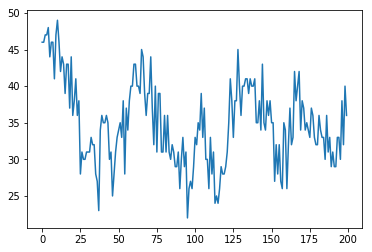

In [12]:
predict_test_labels = list(map(np.argmax,predict_test[:200]))
plt.plot(predict_test_labels)

In [6]:
def to_origin(CLASS): # Transfer class label -> continuous real value
    if CLASS == 0:
        return thresholds[0]
    if CLASS == len(thresholds):
        return thresholds[-1]
    return np.mean(thresholds[CLASS-1:CLASS+1])

In [7]:
def to_origin_multi(CLASSs): # Transfer multiple class labels ->  continuous real values
    thresholds_2 = np.hstack([[thresholds[0]], thresholds, [thresholds[-1]]])
    return list(map(lambda x:np.mean(thresholds_2[x:x+2]), CLASSs))

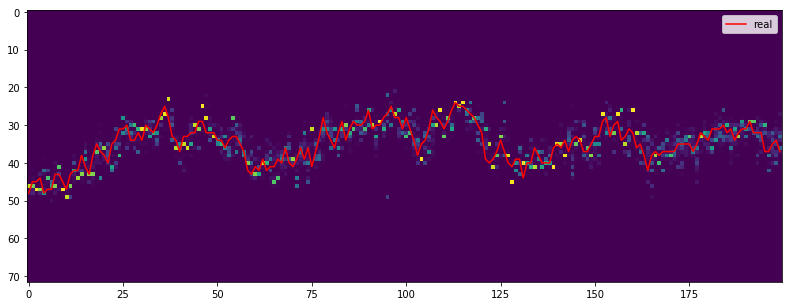

In [13]:
test_y_labels = list(map(np.argmax, sparse.vstack(list(map(to_digit, test_y_origin))).todense()))
predict_test_origin = list(map(to_origin, predict_test_labels))

f = plt.figure(figsize = (15, 5))
axe2 = plt.imshow(predict_test[:200].T)
axe1 = plt.plot(test_y_labels[:200], color='r', label = 'real')
plt.legend()

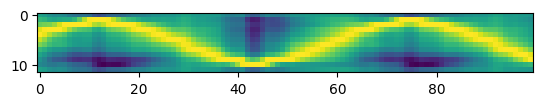

### Moving Window for multi-step prediction

In [14]:
def get_rand():
    current = 0
    num_rand = 100000
    rand_list = np.random.rand(num_rand)
    new_values = []
    num = 100
    while 1:
        num = yield new_values
        if current + num > num_rand:
            rand_list = np.random.rand(num_rand)
            current = 0
        new_values = rand_list[current:current + num]
        current += num

num = test_x.shape[0]
rander = get_rand()
next(rander)

def sample_with_proba(probas):
    thres = np.cumsum(probas, axis = 1)
    return np.sum(rander.send(probas.shape[0]).reshape([-1,1]) > thres, axis = 1)

def do_predict(model, x):
    predict = model.predict(x)
    return predict

def do_multistep_predict(model, x, n_step):
    y_hist = []
    for i in range(n_step):
        #print('progress: %d / %d'%(i+1, n_step))
        y = do_predict(model, x)
        #print(y)
        y_labels = sample_with_proba(y)
        y_hist.append(y_labels)
        x = np.hstack([x[:,1:,0], np.array(to_origin_multi(y_labels)).reshape([-1,1])])[:,:,newaxis]
        #x = np.hstack([x[:,1:,0], test_x[0+i+1:250+i+1:50, -1, :]])[:,:,newaxis]
    y_hist = np.array(y_hist).T
    return y_hist

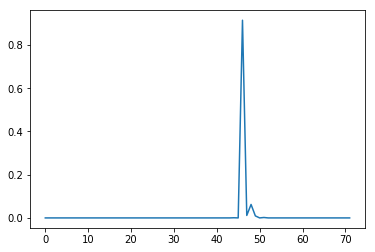

In [33]:
plt.plot(model.predict(test_x[0:1, :]).T)

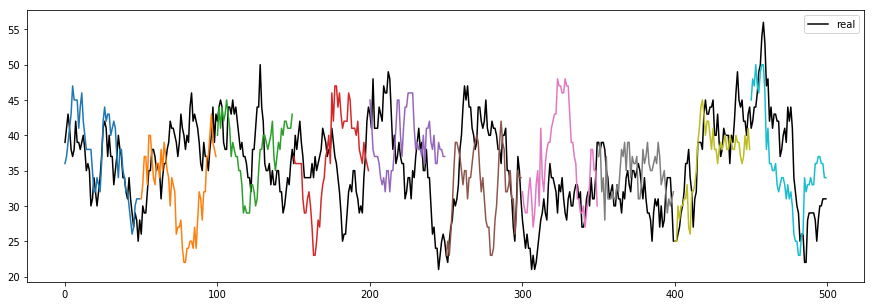

In [15]:
multi_predict_lag = 50
num_groups = 10
show_from = 1000
show_end = show_from + multi_predict_lag * num_groups
num = len(np.arange(show_from, show_end, multi_predict_lag))
#data = np.load('../data/OU_1_1000000.npy')
#scaler = MinMaxScaler()
#data = scaler.transform(data.reshape([-1,1]))
#train_x,train_y,valid_x,valid_y,test_x,test_y = SerieToPieces(data, valid_ratio = 0.0, test_ratio = 0.01)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

#test_x_scaled = scaler.transform(test_x[:,:,0])[:,:,newaxis]
predict_multistep_test = do_multistep_predict(model, test_x[show_from:show_end:multi_predict_lag], 
                                              multi_predict_lag)
#predict_multistep_test = scaler.inverse_transform(predict_multistep_test)

f = plt.figure(figsize = (15,5))
plt.plot(list(map(np.argmax, test_y[show_from:show_end])), 'black', label = 'real')
#plt.plot(test_x[show_from:show_end, -1, 0], label = 'last one of x')
#plt.plot(list(map(np.argmax, predict_test[show_from:show_end])), label = 'single-step predict')
for i in range(predict_multistep_test.shape[0]):
    #a = test_y[i*50:(i+1)*50].reshape([-1])
    #b = np.hstack([a, predict_multistep_test[i]])
    #plt.plot(range((i+0)*50, (i+2)*50), b)
    
    plt.plot(range((i+0)*multi_predict_lag, (i+1)*multi_predict_lag), predict_multistep_test[i], '-')
plt.legend()

### Monte Carlo for multi-step prediction

In [62]:

def SampleOnce(x, label_hist, proba_hist, recursive_depth = 10):
    if recursive_depth == 0:
        return np.argmax(model.predict(x))
    else:
        probas = model.predict(x)
        next_x = sample_with_proba(probas = probas)
        label_hist.append(next_x[0])
        proba_hist.append(probas)
        new_x = np.array(list(x[0,1:,0]) + [to_origin(next_x[0])])
        new_x = new_x[newaxis,:,newaxis]
        SampleOnce(new_x, label_hist, proba_hist, recursive_depth - 1)

def SampleBatch(xs, label_hist, proba_hist, recursive_depth = 10):
    print("recursive_depth:", recursive_depth)
    if recursive_depth == 0:
        return np.argmax(model.predict(xs), axis = 1)
    else:
        probas = model.predict(xs)
        next_xs = sample_with_proba(probas)
        label_hist.append(next_xs)
        proba_hist.append(probas)
        new_xs = np.hstack([xs[:, 1:, 0], np.array(to_origin_multi(next_xs)).reshape([-1, 1])])[:,:,newaxis]
        SampleBatch(new_xs, label_hist, proba_hist, recursive_depth - 1)

def MonteCarlo(x, num_samples, max_recur_depth = 20):
    label_hist = []
    proba_hist = []
    xs = np.repeat(x, num_samples, axis = 0)
    SampleBatch(xs, label_hist, proba_hist, max_recur_depth)
    return label_hist, proba_hist

In [17]:
label_hists, proba_hists = MonteCarlo(test_x[0:1,:,:], 300, 50)

recursive_depth: 50
recursive_depth: 49
recursive_depth: 48
recursive_depth: 47
recursive_depth: 46
recursive_depth: 45
recursive_depth: 44
recursive_depth: 43
recursive_depth: 42
recursive_depth: 41
recursive_depth: 40
recursive_depth: 39
recursive_depth: 38
recursive_depth: 37
recursive_depth: 36
recursive_depth: 35
recursive_depth: 34
recursive_depth: 33
recursive_depth: 32
recursive_depth: 31
recursive_depth: 30
recursive_depth: 29
recursive_depth: 28
recursive_depth: 27
recursive_depth: 26
recursive_depth: 25
recursive_depth: 24
recursive_depth: 23
recursive_depth: 22
recursive_depth: 21
recursive_depth: 20
recursive_depth: 19
recursive_depth: 18
recursive_depth: 17
recursive_depth: 16
recursive_depth: 15
recursive_depth: 14
recursive_depth: 13
recursive_depth: 12
recursive_depth: 11
recursive_depth: 10
recursive_depth: 9
recursive_depth: 8
recursive_depth: 7
recursive_depth: 6
recursive_depth: 5
recursive_depth: 4
recursive_depth: 3
recursive_depth: 2
recursive_depth: 1
recursive

In [63]:
label_hists = []
proba_hists = []
for start_point in range(0, 250, 50):
    label_hists_tmp, proba_hists_tmp = MonteCarlo(test_x[start_point:start_point+1,:,:], 300, 50)
    label_hists += label_hists_tmp
    proba_hists += proba_hists_tmp

recursive_depth: 50
recursive_depth: 49
recursive_depth: 48
recursive_depth: 47
recursive_depth: 46
recursive_depth: 45
recursive_depth: 44
recursive_depth: 43
recursive_depth: 42
recursive_depth: 41
recursive_depth: 40
recursive_depth: 39
recursive_depth: 38
recursive_depth: 37
recursive_depth: 36
recursive_depth: 35
recursive_depth: 34
recursive_depth: 33
recursive_depth: 32
recursive_depth: 31
recursive_depth: 30
recursive_depth: 29
recursive_depth: 28
recursive_depth: 27
recursive_depth: 26
recursive_depth: 25
recursive_depth: 24
recursive_depth: 23
recursive_depth: 22
recursive_depth: 21
recursive_depth: 20
recursive_depth: 19
recursive_depth: 18
recursive_depth: 17
recursive_depth: 16
recursive_depth: 15
recursive_depth: 14
recursive_depth: 13
recursive_depth: 12
recursive_depth: 11
recursive_depth: 10
recursive_depth: 9
recursive_depth: 8
recursive_depth: 7
recursive_depth: 6
recursive_depth: 5
recursive_depth: 4
recursive_depth: 3
recursive_depth: 2
recursive_depth: 1
recursive

In [67]:
np.save('Lorenz-x-multistep-MC-50stepX5-label-hists', np.array(label_hists))
np.save('Lorenz-x-multistep-MC-50stepX5-proba-hists', np.array(proba_hists))

In [231]:
k = np.bincount(np.array(label_hists)[0])

In [233]:
np.argmax(k)

35

In [19]:
def most_frequent_class(label_hists):
    return list(map(lambda x:np.argmax(np.bincount(x)), label_hists))

In [240]:
np.sum(label_hists[0] == 35)

39

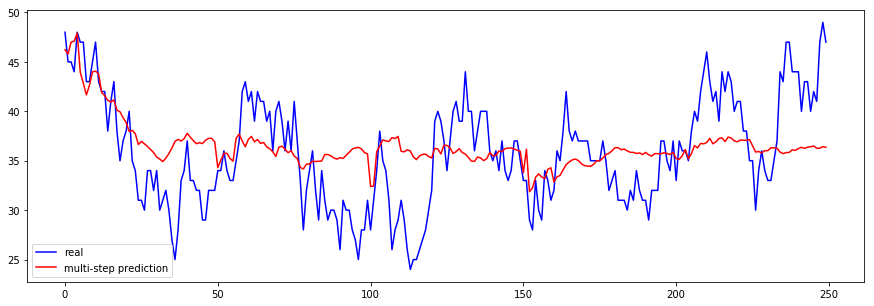

In [34]:
label_hists_mean = most_frequent_class(label_hists)
label_hists_mean = np.mean(np.array(label_hists), axis = 1)
proba_hists_mean = np.mean(np.array(proba_hists), axis = 1).T

plt.figure(figsize = (15,5))
#plt.imshow(proba_hists_mean
plt.plot(np.argmax(test_y[0:250], axis = 1), 'b', label = 'real')
plt.plot(label_hists_mean, 'r', label = 'multi-step prediction')
plt.legend()

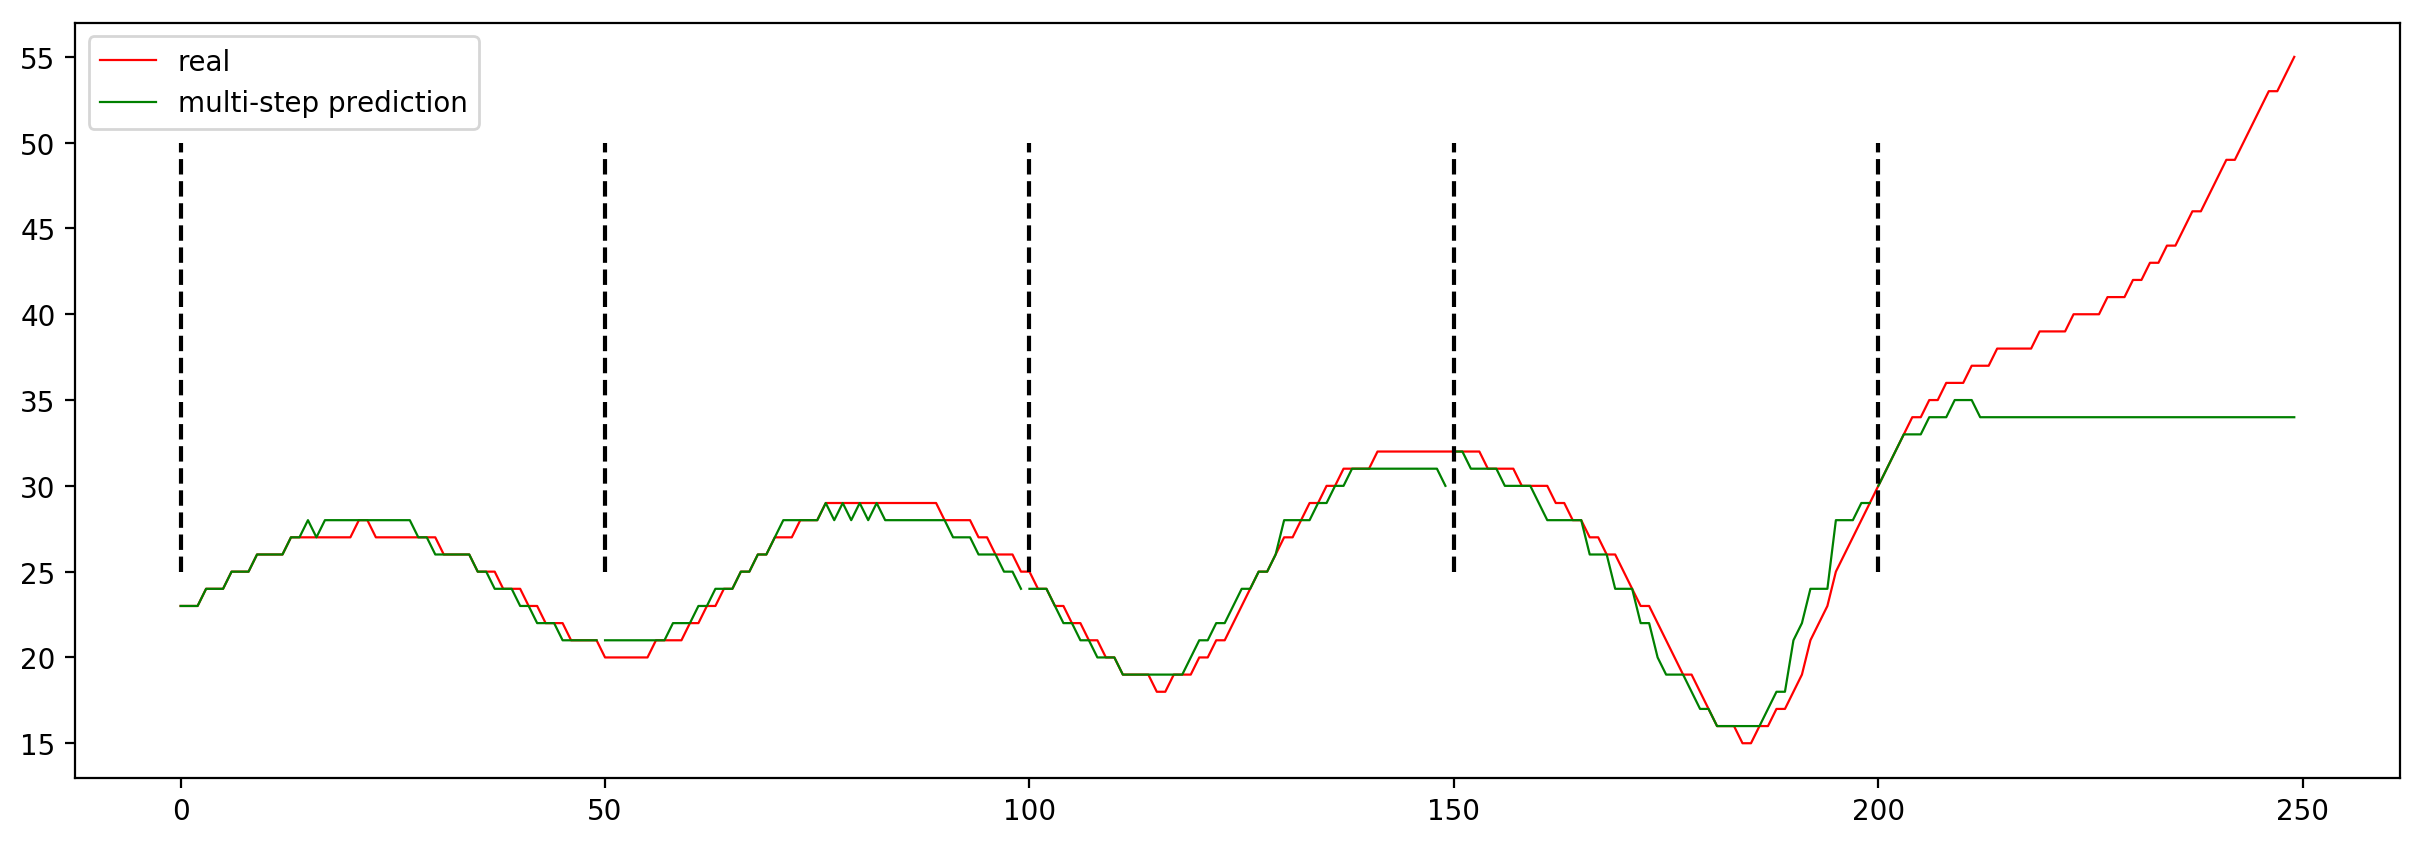

In [64]:
label_hists_mean = most_frequent_class(label_hists)
#label_hists_mean = np.mean(np.array(label_hists), axis = 1)
proba_hists_mean = np.mean(np.array(proba_hists), axis = 1).T

plt.figure(dpi=200, figsize=(15,5))
#plt.imshow(proba_hists_mean
plt.plot(np.argmax(test_y[:250], axis = 1), 'r', label = 'real', linewidth = 0.8)
for start_point in range(0, 250, 50):
    plt.plot(np.arange(start_point, start_point+50), label_hists_mean[start_point:start_point+50], linewidth = 0.8, c='g', label = 'multi-step prediction')
    plt.plot([start_point, start_point], [25, 50], '--', c = 'black')
plt.legend(['real', 'multi-step prediction'])

<module 'matplotlib.pyplot' from '/home/duxin/.pyenv/versions/anaconda3-5.1.0/envs/venv510/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
def to_class(y):
    return np.argmax(to_digit(y))

def to_class_multi(ys):
    return list(map(to_class, ys))

In [208]:
to_class_multi([0.5, 0.3])

[36, 26]

In [211]:
test_y.shape

(4998, 72)

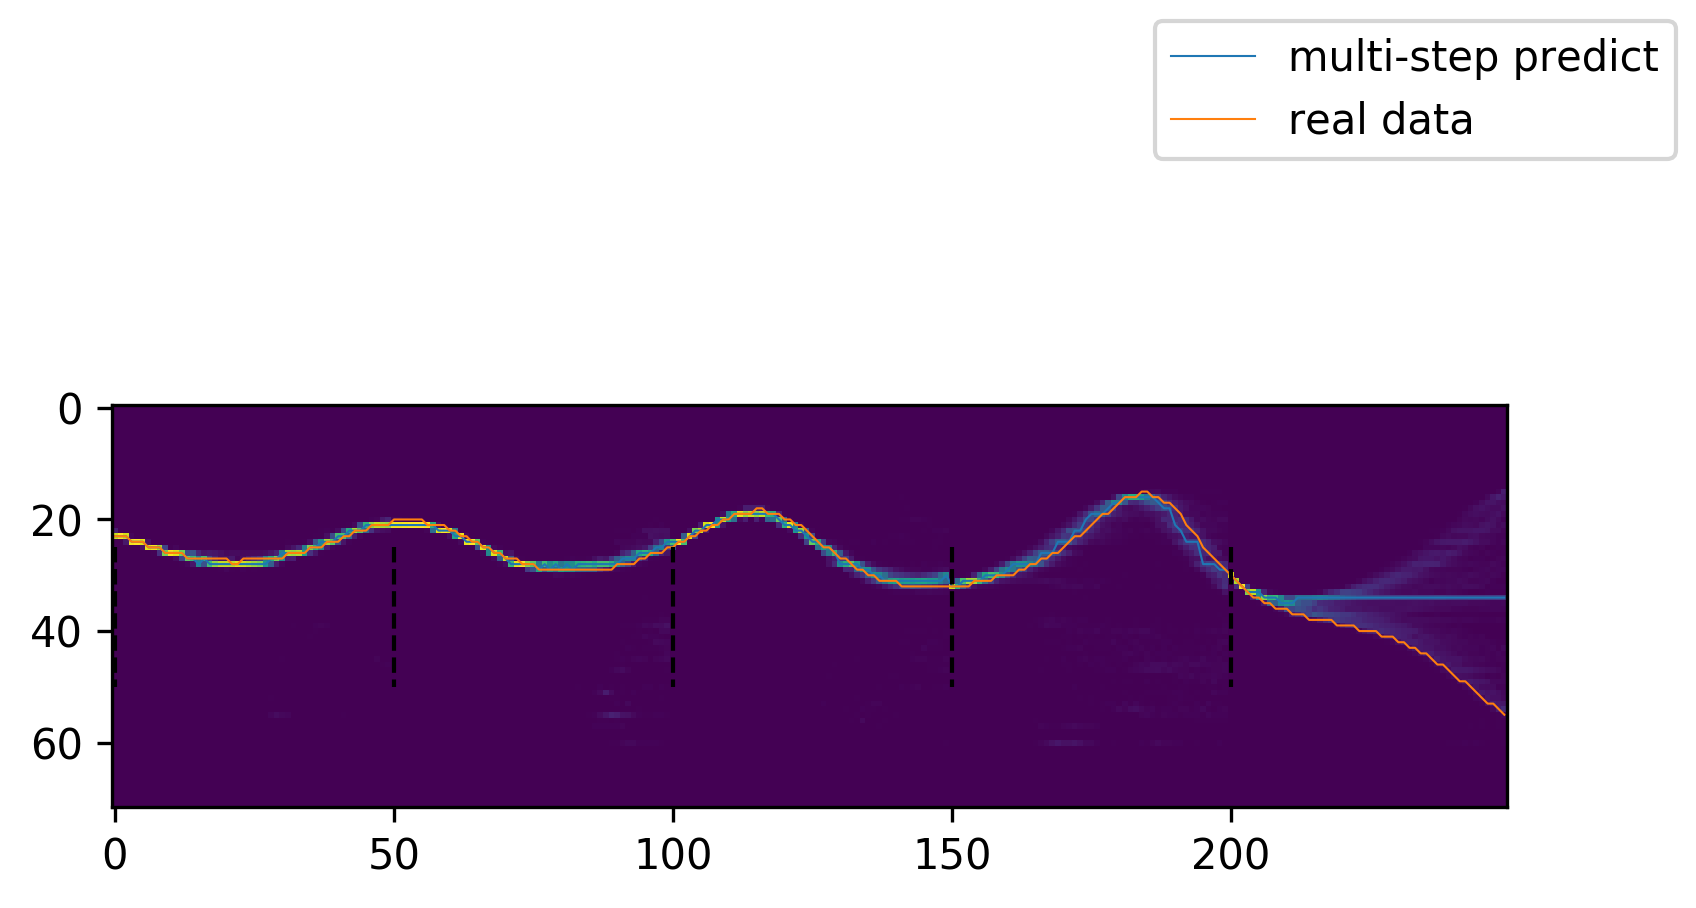

In [65]:
f = plt.figure(dpi = 300)
axe1 = plt.imshow(proba_hists_mean[:, :250])
axe2 = plt.plot(label_hists_mean[:250], label = 'multi-step predict', linewidth = 0.5)
axe3 = plt.plot(np.argmax(test_y[0:250], axis = 1), label = 'real data', linewidth = 0.5)
f.legend()
for start_point in range(0, 250, 50):
    plt.plot([start_point, start_point], [25, 50], '--', c = 'black', linewidth = 1)

In [113]:
model.predict(test_x[0:1, :, :]).shape

(1, 72)

progress 1 / 494
progress 11 / 494
progress 21 / 494
progress 31 / 494
progress 41 / 494
progress 51 / 494
progress 61 / 494
progress 71 / 494
progress 81 / 494
progress 91 / 494
progress 101 / 494
progress 111 / 494
progress 121 / 494
progress 131 / 494
progress 141 / 494
progress 151 / 494
progress 161 / 494
progress 171 / 494
progress 181 / 494
progress 191 / 494
progress 201 / 494
progress 211 / 494
progress 221 / 494
progress 231 / 494
progress 241 / 494
progress 251 / 494
progress 261 / 494
progress 271 / 494
progress 281 / 494
progress 291 / 494
progress 301 / 494
progress 311 / 494
progress 321 / 494
progress 331 / 494
progress 341 / 494
progress 351 / 494
progress 361 / 494
progress 371 / 494
progress 381 / 494
progress 391 / 494
progress 401 / 494
progress 411 / 494
progress 421 / 494
progress 431 / 494
progress 441 / 494
progress 451 / 494
progress 461 / 494
progress 471 / 494
progress 481 / 494
progress 491 / 494
progress 494 / 494


### Financial Data Test

In [42]:
price = price_util.GetStockPricesWithinDay(stock_name = 'BABA', start_time = '20161101 09:00:00', end_time = '20161101 18:00:00', interval = 300)

progress 78 / 78.


In [ ]:
price_util.GetStockPricesWithinDay(stock_name = 'BABA', start_time = '20161102 09:00:00', end_time = '20161102 18:00:00', interval = 3600)

In [ ]:
data = price_util.GetStockPriceByDays('BABA', '20150101', '20180101', interval = 1, sample_moment = 'end', as_dataframe = False)
np.save('BABA-alldays', data)

In [71]:
if __name__ == '__main__':
    data = np.load('BABA-alldays.npy')[:, 1].T
    num_class = 52
    #data = data[:100000]
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape([-1,1]))
    (train_x,train_y_origin,valid_x,valid_y_origin,test_x,test_y_origin), (train_y, valid_y, test_y), to_digit, thresholds = DatasetAbsoluteDiscretization(
        data, num_class = num_class, padding = '10%', valid_ratio = 0.0, test_ratio = 0.2, shuffle = True, return_sparse = True)
    
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    
    model = train_model_discrete(train_x, train_y, num_class = num_class, epochs = 100, batch_size = 64)
    
    train_x = train_x[:1000]
    train_y = train_y[:1000]
    
    predict_train = model.predict(train_x)
    #predict_train = scaler.inverse_transform(predict_train.reshape([-1, 1]))
    #train_y = scaler.inverse_transform(train_y)
    predict_test = model.predict(test_x)
    #predict_test = scaler.inverse_transform(predict_test.reshape([-1, 1]))
    #test_y = scaler.inverse_transform(test_y)
    print('Finished.')


Epoch 1/100
6/6 [==============================] - 2s - loss: 3.6881     
Epoch 2/100
6/6 [==============================] - 0s - loss: 3.0716     
Epoch 3/100
6/6 [==============================] - 0s - loss: 2.9543     
Epoch 4/100
6/6 [==============================] - 1s - loss: 2.7819     
Epoch 5/100
6/6 [==============================] - 0s - loss: 2.8796     
Epoch 6/100
6/6 [==============================] - 0s - loss: 2.3564     
Epoch 7/100
6/6 [==============================] - 0s - loss: 2.3898     
Epoch 8/100
6/6 [==============================] - 0s - loss: 2.2773     
Epoch 9/100
6/6 [==============================] - 0s - loss: 2.2289     
Epoch 10/100
6/6 [==============================] - 1s - loss: 2.2001     
Epoch 11/100
6/6 [==============================] - 1s - loss: 2.1019     
Epoch 12/100
6/6 [==============================] - 1s - loss: 2.0826     
Epoch 13/100
6/6 [==============================] - 0s - loss: 2.0091     
Epoch 14/100
6/6 [================

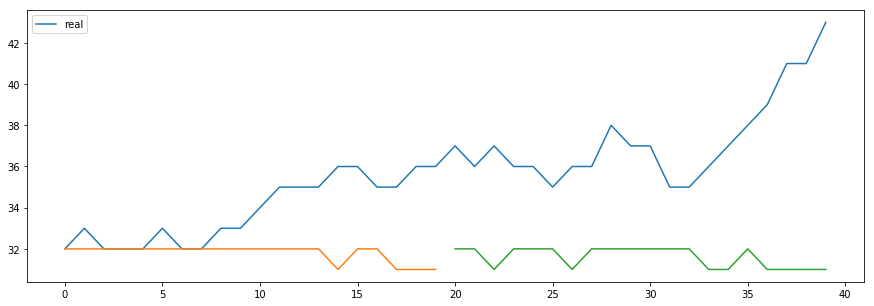

In [72]:
multi_predict_lag = 20
num_groups = 2
show_from = 0
show_end = show_from + multi_predict_lag * num_groups
num = len(np.arange(show_from, show_end, multi_predict_lag))
#data = np.load('../data/OU_1_1000000.npy')
#scaler = MinMaxScaler()
#data = scaler.transform(data.reshape([-1,1]))
#train_x,train_y,valid_x,valid_y,test_x,test_y = SerieToPieces(data, valid_ratio = 0.0, test_ratio = 0.01)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

#test_x_scaled = scaler.transform(test_x[:,:,0])[:,:,newaxis]
predict_multistep_test = do_multistep_predict(model, test_x[show_from:show_end:multi_predict_lag], 
                                              multi_predict_lag)
#predict_multistep_test = scaler.inverse_transform(predict_multistep_test)

f = plt.figure(figsize = (15,5))
plt.plot(list(map(np.argmax, test_y[show_from:show_end])), label = 'real')
#plt.plot(test_x[show_from:show_end, -1, 0], label = 'last one of x')
#plt.plot(list(map(np.argmax, predict_test[show_from:show_end])), label = 'single-step predict')
for i in range(predict_multistep_test.shape[0]):
    #a = test_y[i*50:(i+1)*50].reshape([-1])
    #b = np.hstack([a, predict_multistep_test[i]])
    #plt.plot(range((i+0)*50, (i+2)*50), b)
    
    plt.plot(range((i+0)*multi_predict_lag, (i+1)*multi_predict_lag), predict_multistep_test[i], '-')
plt.legend()